# TCLab Identification

# Identification

## Step Testing

The following cells perform 'experiments' using the TClab simulation capability. Comment out the `setup` line to use this with actual TCLab hardware.

### Experiment 1

TCLab version 0.4.8
Simulated TCLab


<IPython.core.display.Javascript object>


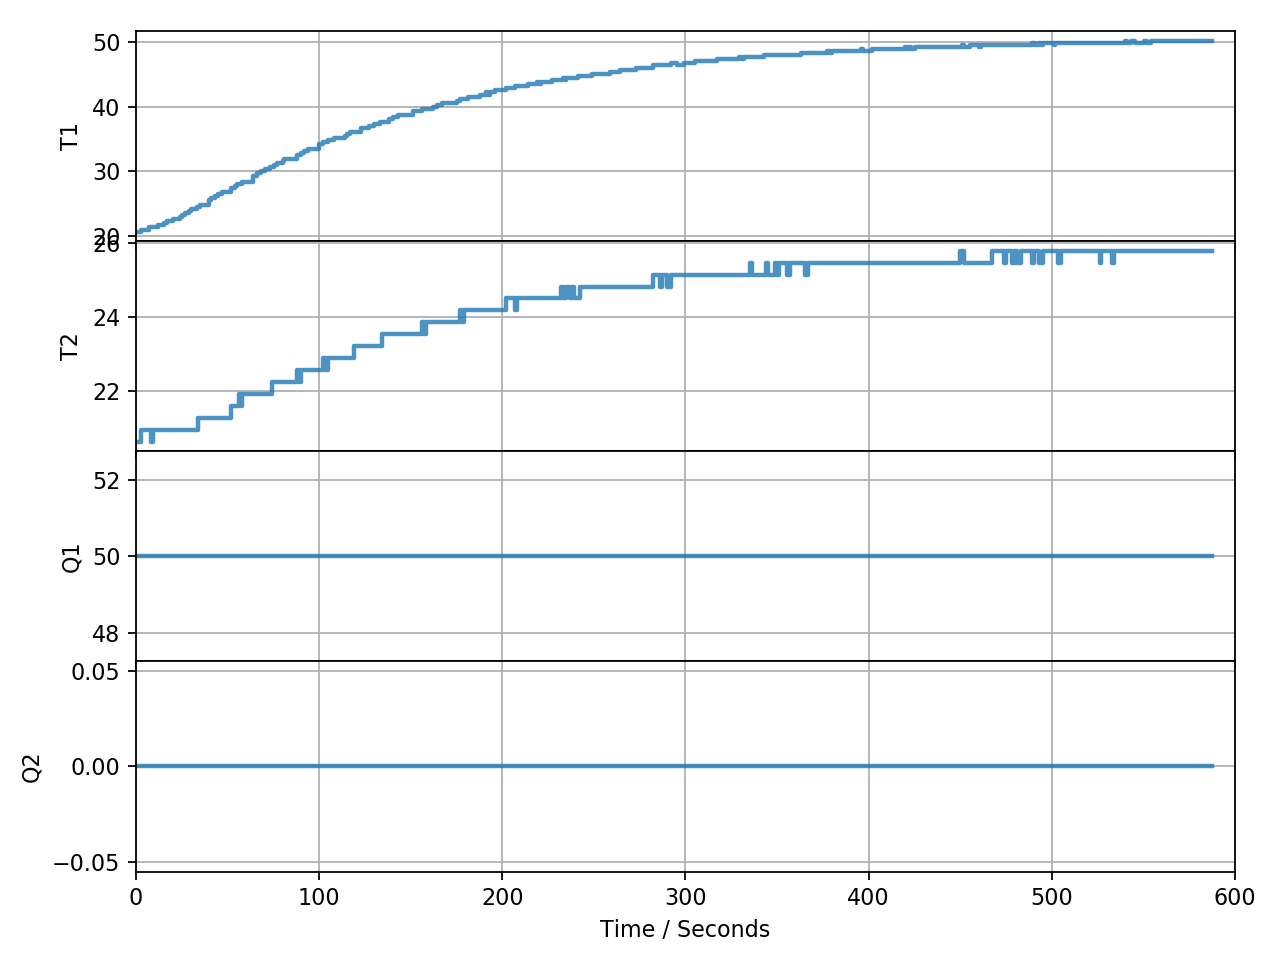

TCLab Model disconnected successfully.


In [1]:
%matplotlib notebook
from tclab import TCLab, setup, Historian, Plotter, clock
TCLab = setup(connected=False, speedup=20)
tf = 600

with TCLab() as lab:
    h = Historian(lab.sources)
    p = Plotter(h, tf)
    lab.U1 = 50
    lab.U2 = 0
    for t in clock(tf):
         v = p.update(t)
        
h.to_csv('step01.csv')

### Experiment 2

TCLab version 0.4.8
Simulated TCLab


<IPython.core.display.Javascript object>


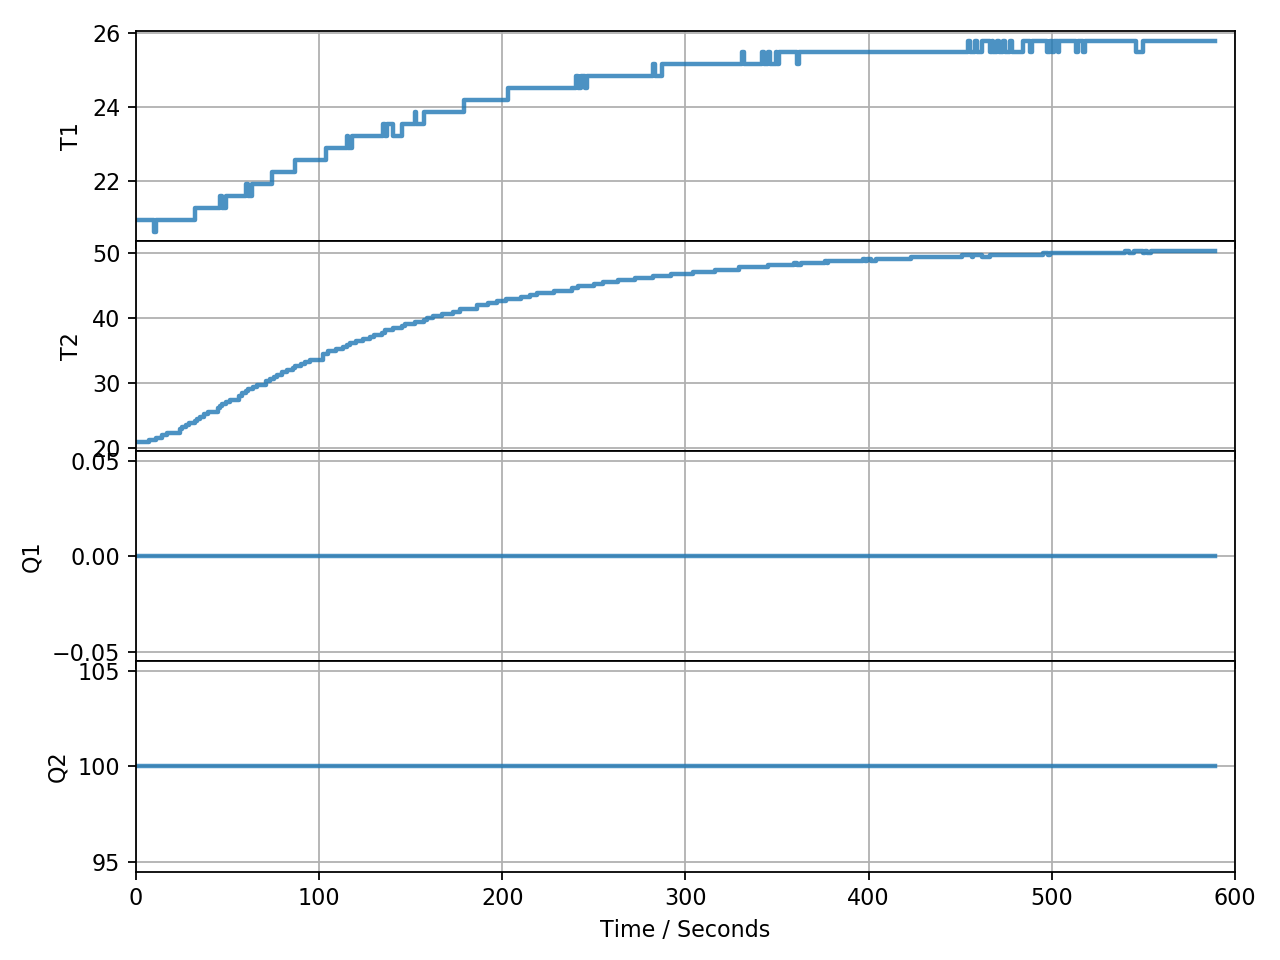

TCLab Model disconnected successfully.


In [2]:
%matplotlib notebook
from tclab import TCLab, setup, Historian, Plotter, clock
TCLab = setup(connected=False, speedup=20)
tf = 600

with TCLab() as lab:
    h = Historian(lab.sources)
    p = Plotter(h, tf)
    lab.U1 = 0
    lab.U2 = 100
    for t in clock(tf):
        p.update(t)

h.to_csv('step02.csv')

## Read Data from files using Pandas Library

The Pandas Library is an extraordinarily useful library for working with complex data. In the case we're working with data from multiple files. Our strategy is to read each into an entry in a dictionary nameed `data` that will store all of the collected data.

In [2]:
import pandas as pd

files = ['step01.csv', 'step02.csv']
data = {}
for file in files:
    data[file] = pd.read_csv(file)

FileNotFoundError: File b'step02.csv' does not exist

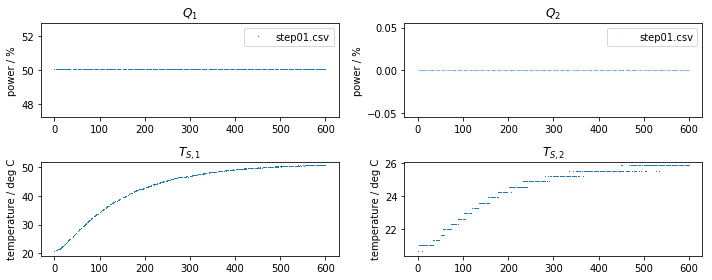

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

# create axes to display the data
plt.figure(figsize=(10,4))
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,2,3)
ax4 = plt.subplot(2,2,4)
    
for expt in data.keys():
    ax1.plot(data[expt]['Time'], data[expt]['Q1'], ',', ms=0.2)
    ax2.plot(data[expt]['Time'], data[expt]['Q2'], '.', ms=0.2)
    ax3.plot(data[expt]['Time'], data[expt]['T1'], ',', ms=0.2)
    ax4.plot(data[expt]['Time'], data[expt]['T2'], ',', ms=0.2)

ax1.set_title('$Q_1$')
ax1.set_ylabel('power / %')
ax1.legend(data.keys())

ax2.set_title('$Q_2$')
ax2.set_ylabel('power / %')
ax2.legend(data.keys())

ax3.set_title('$T_{S,1}$')
ax3.set_ylabel('temperature / deg C')

ax4.set_title('$T_{S,2}$')
ax4.set_ylabel('temperature / deg C')

plt.tight_layout()

## Modeling

### Energy Balances

\begin{align}
C^H_p\frac{dT_{H,1}}{dt} & = U_a(T_{amb} - T_{H,1}) + U_b(T_{H,2}-T_{H,1}) + U_c(T_{S,1} - T_{H,1}) + P_1u_1\\
C^S_p\frac{dT_{S,1}}{dt} & = U_c(T_{H,1} - T_{S,1})  \\
C^H_p\frac{dT_{H,2}}{dt} & = U_a(T_{amb} - T_{H,2}) + U_b(T_{H,1}-T_{H,2}) + U_c(T_{S,2} - T_{H,2}) + P_2u_2\\
C^S_p\frac{dT_{S,2}}{dt} & = U_c(T_{H,2} - T_{S,2}) 
\end{align}

In [4]:
import control
import numpy as np

def create_model(Ua=0.043, Ub=0.022, Uc=0.036, CpH=6.38, CpS=0.98):
    
    P1 = 0.04
    P2 = 0.02
    
    A = np.array()

    B = np.array()

    C = np.array()

    D = np.array()

    return control.StateSpace(A, B, C, D)

ss = create_model()

TypeError: Required argument 'object' (pos 1) not found

### Plot Simulation

NameError: name 'ss' is not defined

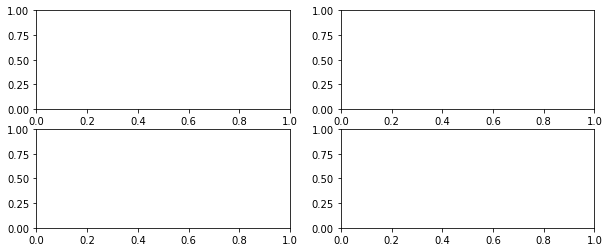

In [5]:
%matplotlib inline

# create axes to display the data
plt.figure(figsize=(10,4))
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,2,3)
ax4 = plt.subplot(2,2,4)
    
for expt in data.keys():
    
    # create a uniform time grid
    t = data[expt]['Time']
    t = np.linspace(min(t), max(t), round(max(t) - min(t) + 1))
    
    # interpolate experimental results over uniform time grid
    Q1 = np.interp(t, data[expt]['Time'], data[expt]['Q1'])
    Q2 = np.interp(t, data[expt]['Time'], data[expt]['Q2'])
    
    # estimate ambient temperatures using the initial average measurements
    Tamb = (data[expt]['T1'][0] + data[expt]['T2'][0])/2
    
    # simulate response
    t, y, x = control.forced_response(ss, t, [Q1, Q2])
    ax1.plot(t, Q1, '.', ms=0.2)
    ax2.plot(t, Q2, '.', ms=0.2)
    ax3.plot(t, y[0] + Tamb)
    ax4.plot(t, y[1] + Tamb)

ax1.set_title('$Q_1$')
ax1.set_ylabel('power / %')
ax1.legend(data.keys())

ax2.set_title('$Q_2$')
ax2.set_ylabel('power / %')
ax2.legend(data.keys())

ax3.set_title('$T_{S,1}$')
ax3.set_ylabel('temperature / deg C')

ax4.set_title('$T_{S,2}$')
ax4.set_ylabel('temperature / deg C')

plt.tight_layout()

## Comparing the Model to the Step Response Data

In [6]:
%matplotlib inline

def create_plot(data, ss):
    
    # create axes to display the data
    plt.figure(figsize=(10,8))
    ax1 = plt.subplot(3,2,1)
    ax2 = plt.subplot(3,2,2)
    ax3 = plt.subplot(3,2,3)
    ax4 = plt.subplot(3,2,4)
    ax5 = plt.subplot(3,2,5)
    ax6 = plt.subplot(3,2,6)
    
    pred_err = []

    for expt in data.keys():

        # create uniform time grid
        t = data[expt]['Time']
        t = np.linspace(min(t), max(t), round(max(t) - min(t) + 1))

        # interpolate experimental data onto a uniform time grid
        Q1 = np.interp(t, data[expt]['Time'], data[expt]['Q1'])
        Q2 = np.interp(t, data[expt]['Time'], data[expt]['Q2'])
        T1 = np.interp(t, data[expt]['Time'], data[expt]['T1'])
        T2 = np.interp(t, data[expt]['Time'], data[expt]['T2'])

        # get ambient temperatures
        Tamb = (data[expt]['T1'][0] + data[expt]['T2'][0])/2

        # compute simulated response
        t, y, x = control.forced_response(ss, t, [Q1, Q2])
        
        # overlay simulation and experimental responses
        ax1.plot(t, Q1, '.', ms=0.2)
        ax2.plot(t, Q2, '.', ms=0.2)
        line, = ax3.plot(t, y[0] + Tamb)
        ax3.plot(data[expt]['Time'], data[expt]['T1'], '.', ms=0.2, color=line.get_color())
        line, = ax4.plot(t, y[1] + Tamb)
        ax4.plot(data[expt]['Time'], data[expt]['T2'], '.', ms=0.2, color=line.get_color())
        
        ax5.plot(t, x[0] + Tamb)
        ax5.plot(data[expt]['Time'], data[expt]['T1'], '.', ms=0.2, color=line.get_color())
        ax6.plot(t, x[2] + Tamb)
        ax6.plot(data[expt]['Time'], data[expt]['T2'], '.', ms=0.2, color=line.get_color())
        
        pred_err.append(y[0] + Tamb - T1)
        pred_err.append(y[1] + Tamb - T2)

    ax1.set_title('$Q_1$')
    ax1.set_ylabel('power / %')
    ax1.legend(data.keys())

    ax2.set_title('$Q_2$')
    ax2.set_ylabel('power / %')
    ax2.legend(data.keys())

    ax3.set_title('$T_{S,1}$')
    ax3.set_ylabel('temperature / deg C')

    ax4.set_title('$T_{S,2}$')
    ax4.set_ylabel('temperature / deg C')

    ax5.set_title('$T_{H,1}$')
    ax5.set_ylabel('temperature / deg C')

    ax6.set_title('$T_{H,2}$')
    ax6.set_ylabel('temperature / deg C')

    plt.tight_layout()
    
    return pred_err
    
ss = create_model()
err = create_plot(data, ss)

TypeError: Required argument 'object' (pos 1) not found

## Fitting the Model

In [7]:
%matplotlib inline
from ipywidgets import interact

def fit_model(Ua=0.043, Ub=0.022, Uc=0.036, CpH=6.38, CpS=0.98):
    ss = create_model(Ua, Ub, Uc, CpH, CpS)
    create_plot(data, ss)
    print('Ua =', Ua)
    print('Ub =', Ub)
    print('Uc =', Uc)
    print('CpH =', CpH)
    print('CpS =', CpS)

interact(fit_model,
    Ua = (0, 0.1, .001),
    Ub = (0, 0.1, .001),
    Uc = (0, 0.1, 0.001),
    CpH = (0, 10, .01),
    CpS = (0, 10, .01))

interactive(children=(FloatSlider(value=0.043, description='Ua', max=0.1, step=0.001), FloatSlider(value=0.022…

<function __main__.fit_model(Ua=0.043, Ub=0.022, Uc=0.036, CpH=6.38, CpS=0.98)>